In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
from scipy.stats import norm, skew

# importing models
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


# Data Processing
### (These are CRUCIAL , non optional steps . Real world data is even more noisy)
### Not all data is 'Clean' enough to be used directly for mathematical models. We need to 'Clean' it first !
Remove Outliers
Fill up NULL and missing data . Most models can't handle them.

In [3]:
## saving the ID's for the test data for the very end 
test_id = test['Id']

## taking out the ID column because its not usefull
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [4]:
df = pd.concat([train.SalePrice, np.log(train.SalePrice + 1).rename('LogSalePrice')], axis=1, names=['SalePrice', 'LogSalePrice'])
df.head()

,SalePrice,LogSalePrice
0,208500,12.247699
1,181500,12.109016
2,223500,12.317171
3,140000,11.849405
4,250000,12.429220


Text(0.5, 0, 'Log SalePrice')

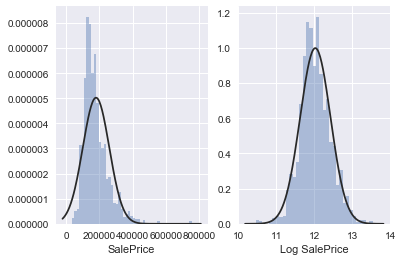

In [5]:
plt.subplot(1, 2, 1)
sns.distplot(train.SalePrice, kde=False, fit = norm)

plt.subplot(1, 2, 2)
sns.distplot(np.log(train.SalePrice + 1), kde=False, fit = norm)
plt.xlabel('Log SalePrice')

In [6]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print("Train set size:", train.shape)
print("Test set size:", test.shape)
print("Features set size:", features.shape)

Train set size: (1460, 80)
Test set size: (1459, 79)
Features set size: (2919, 79)


In [7]:
categorical_values = ['Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType', 
                    'Utilities', 'Functional', 'MSZoning', 'MasVnrType', 'BsmtFinType1',
                    'BsmtFinType2', 'BsmtQual', 'BsmtExposure', 'BsmtCond', 'GarageType',
                    'GarageFinish', 'GarageQual', 'GarageCond', 'FireplaceQu', 'Fence', 
                    'Alley', 'MiscFeature', 'PoolQC', 'MSSubClass', 'LotShape',
                    'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood','Condition1', 
                    'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
                    'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating',
                    'HeatingQC', 'CentralAir', 'Electrical', 'PavedDrive', 'SaleCondition', 'Street',] 

In [8]:
## allows us to call null_count over and over again to see how we are doing on cleaning our data
def null_count():
    nulls = np.sum(features.isnull())
    nullcols = nulls.loc[(nulls != 0)]
    dtypes = features.dtypes
    dtypes2 = dtypes.loc[(nulls != 0)]
    info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
    print(info)
    print("There are", len(nullcols), "columns with missing values")

In [9]:
null_count()

                 0        1
PoolQC        2909   object
MiscFeature   2814   object
Alley         2721   object
Fence         2348   object
FireplaceQu   1420   object
LotFrontage    486  float64
GarageFinish   159   object
GarageQual     159   object
GarageCond     159   object
GarageYrBlt    159  float64
GarageType     157   object
BsmtExposure    82   object
BsmtCond        82   object
BsmtQual        81   object
BsmtFinType2    80   object
BsmtFinType1    79   object
MasVnrType      24   object
MasVnrArea      23  float64
MSZoning         4   object
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
Functional       2   object
Utilities        2   object
GarageArea       1  float64
GarageCars       1  float64
Electrical       1   object
KitchenQual      1   object
TotalBsmtSF      1  float64
BsmtUnfSF        1  float64
BsmtFinSF2       1  float64
BsmtFinSF1       1  float64
Exterior2nd      1   object
Exterior1st      1   object
SaleType         1   object
There are 34 columns

In [10]:
# Since these column are actually a category , using a numerical number will lead the model to assume
# that it is numerical , so we convert to string .
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [11]:
## Filling these with the most frequent value in these columns .
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [12]:
null_count()

                 0        1
PoolQC        2909   object
MiscFeature   2814   object
Alley         2721   object
Fence         2348   object
FireplaceQu   1420   object
LotFrontage    486  float64
GarageYrBlt    159  float64
GarageFinish   159   object
GarageQual     159   object
GarageCond     159   object
GarageType     157   object
BsmtExposure    82   object
BsmtCond        82   object
BsmtQual        81   object
BsmtFinType2    80   object
BsmtFinType1    79   object
MasVnrType      24   object
MasVnrArea      23  float64
MSZoning         4   object
Functional       2   object
BsmtHalfBath     2  float64
BsmtFullBath     2  float64
Utilities        2   object
KitchenQual      1   object
TotalBsmtSF      1  float64
GarageCars       1  float64
GarageArea       1  float64
BsmtUnfSF        1  float64
BsmtFinSF2       1  float64
BsmtFinSF1       1  float64
Electrical       1   object
There are 31 columns with missing values


In [13]:
## Filling these columns With most logical value for these columns 
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Functional'] = features['Functional'].fillna('Typ')   
features["PoolQC"] = features["PoolQC"].fillna("None")

In [14]:
null_count()

                 0        1
MiscFeature   2814   object
Alley         2721   object
Fence         2348   object
FireplaceQu   1420   object
LotFrontage    486  float64
GarageCond     159   object
GarageYrBlt    159  float64
GarageFinish   159   object
GarageQual     159   object
GarageType     157   object
BsmtCond        82   object
BsmtExposure    82   object
BsmtQual        81   object
BsmtFinType2    80   object
BsmtFinType1    79   object
MasVnrType      24   object
MasVnrArea      23  float64
MSZoning         4   object
BsmtHalfBath     2  float64
BsmtFullBath     2  float64
Utilities        2   object
TotalBsmtSF      1  float64
GarageCars       1  float64
GarageArea       1  float64
BsmtFinSF2       1  float64
BsmtFinSF1       1  float64
BsmtUnfSF        1  float64
There are 27 columns with missing values


In [15]:
### Missing data in GarageYrBit most probably means missing Garage , 
### so replace NaN with none and convert to string because year is a category . 
features['GarageYrBlt'] = features['GarageYrBlt'].fillna('None')
features['GarageYrBlt'] = features['GarageYrBlt'].astype(str)
for col in ('GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
    
### Same with basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

In [16]:
null_count()

                 0        1
MiscFeature   2814   object
Alley         2721   object
Fence         2348   object
FireplaceQu   1420   object
LotFrontage    486  float64
MasVnrType      24   object
MasVnrArea      23  float64
MSZoning         4   object
Utilities        2   object
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
BsmtFinSF1       1  float64
BsmtFinSF2       1  float64
BsmtUnfSF        1  float64
TotalBsmtSF      1  float64
There are 15 columns with missing values


In [17]:
features['BsmtFullBath'].index[features['BsmtFullBath'].apply(np.isnan)]

Int64Index([2120, 2188], dtype='int64')

In [18]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [19]:
null_count()

                 0        1
MiscFeature   2814   object
Alley         2721   object
Fence         2348   object
FireplaceQu   1420   object
LotFrontage    486  float64
MasVnrType      24   object
MasVnrArea      23  float64
Utilities        2   object
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
BsmtFinSF1       1  float64
BsmtFinSF2       1  float64
BsmtUnfSF        1  float64
TotalBsmtSF      1  float64
There are 14 columns with missing values


In [20]:
features['MiscFeature'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: MiscFeature, dtype: object

In [21]:
# all of these had a none option, and now we just fill with that
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

In [22]:
null_count()

                0        1
LotFrontage   486  float64
MasVnrArea     23  float64
BsmtFullBath    2  float64
BsmtHalfBath    2  float64
BsmtFinSF1      1  float64
BsmtFinSF2      1  float64
BsmtUnfSF       1  float64
TotalBsmtSF     1  float64
There are 8 columns with missing values


In [23]:
# if a MasVnrArea value is missing it would make sense that the house just doesn't have any stone work
features['MasVnrArea'] = features['MasVnrArea'].fillna(0)
# same for full and half baths in the bacement. there may just be no bathroom so fill with 0.
features['BsmtFullBath'] = features['BsmtFullBath'].fillna(0)
features['BsmtHalfBath'] = features['BsmtHalfBath'].fillna(0)
# it is also safe to assume that if there is a missing vlaue for BsmtFinSF1 thene the is no finished bacement
features['BsmtFinSF1'] = features['BsmtFinSF1'].fillna(0)
features['BsmtFinSF2'] = features['BsmtFinSF2'].fillna(0)
features['BsmtUnfSF'] = features['BsmtUnfSF'].fillna(0)
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

In [24]:
null_count()

               0        1
LotFrontage  486  float64
There are 1 columns with missing values


In [25]:
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [26]:
null_count()

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


In [27]:
## For ex, if PoolArea = 0 , Then HasPool = 0 too
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [28]:
features.shape

(2919, 84)

In [29]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,2,2008,WD,Normal,0,1,1,1,0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,5,2007,WD,Normal,0,0,1,1,1
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,9,2008,WD,Normal,0,1,1,1,1
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,2,2006,WD,Abnorml,0,1,1,1,1
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,12,2008,WD,Normal,0,1,1,1,1


In [30]:
from sklearn.preprocessing import LabelEncoder
for i in features.columns:
    le_c = LabelEncoder()
    if i in categorical_values:
        features[i] = le_c.fit_transform(features[str(i)])

In [31]:
## this is here because for some reason it didn't do a good job encoding this column
le_g = LabelEncoder()
features['GarageYrBlt'] = le_c.fit_transform(features['GarageYrBlt'])

In [32]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,10,3,65.0,8450,1,1,3,3,0,4,...,0,2,2008,8,4,0,1,1,1,0
1,5,3,80.0,9600,1,1,3,3,0,2,...,0,5,2007,8,4,0,0,1,1,1
2,10,3,68.0,11250,1,1,0,3,0,4,...,0,9,2008,8,4,0,1,1,1,1
3,11,3,60.0,9550,1,1,0,3,0,0,...,0,2,2006,8,0,0,1,1,1,1
4,10,3,84.0,14260,1,1,0,3,0,2,...,0,12,2008,8,4,0,1,1,1,1


In [33]:
X = features.iloc[:len(train), :]
X_sub = features.iloc[len(train):, :]
X.shape, test.shape, X_sub.shape

((1460, 84), (1459, 79), (1459, 84))

In [34]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,10,3,65.0,8450,1,1,3,3,0,4,...,0,2,2008,8,4,0,1,1,1,0
1,5,3,80.0,9600,1,1,3,3,0,2,...,0,5,2007,8,4,0,0,1,1,1
2,10,3,68.0,11250,1,1,0,3,0,4,...,0,9,2008,8,4,0,1,1,1,1
3,11,3,60.0,9550,1,1,0,3,0,0,...,0,2,2006,8,0,0,1,1,1,1
4,10,3,84.0,14260,1,1,0,3,0,2,...,0,12,2008,8,4,0,1,1,1,1


In [35]:
X_sub.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
1460,5,2,80.0,11622,1,1,3,3,0,4,...,0,6,2010,8,4,0,0,1,1,0
1461,5,3,81.0,14267,1,1,0,3,0,0,...,12500,6,2010,8,4,0,0,1,1,0
1462,10,3,74.0,13830,1,1,0,3,0,4,...,0,3,2010,8,4,0,1,1,1,1
1463,10,3,78.0,9978,1,1,0,3,0,4,...,0,6,2010,8,4,0,1,1,1,1
1464,0,3,43.0,5005,1,1,0,1,0,4,...,0,1,2010,8,4,0,0,1,1,0


In [36]:
missing_values_dict = {}
for column in features.columns:
    missing_values_dict[column] = features[column].isnull().sum()
no_missing_values = []
missing_values = []
for i in missing_values_dict:
    if missing_values_dict[i] == 0:
        no_missing_values.append(i)
    else:
        missing_values.append(i)
        

print('number of missing values: ' + str(len(missing_values)))
print('number of values not missing: ' + str(len(no_missing_values)))

number of missing values: 0
number of values not missing: 84


In [37]:
score_lr = cross_val_score(linear_model.LinearRegression(), X, train['SalePrice'], cv=8)
np.average(score_lr)

0.7983910329732349

In [38]:
score_dt = cross_val_score(DecisionTreeRegressor(), X,  train['SalePrice'], cv=8)
np.average(score_dt)

0.7191015718353024

In [39]:
score_rf = cross_val_score(RandomForestRegressor(n_estimators = 1000), X, train['SalePrice'], cv=8)
np.average(score_rf)

0.8628571497426668

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,train['SalePrice'], test_size=0)
# Fitting the Regression model to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 0)
regressor.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [41]:
y_pred = regressor.predict(X_sub)

In [42]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = y_pred
sub.head()

,Id,SalePrice
0,1461,126458.641
1,1462,155075.064
2,1463,178663.467
3,1464,182411.126
4,1465,199638.214


In [43]:
sub.to_csv('submission.csv',index=False)

In [44]:
s = pd.read_csv('submission.csv')

In [45]:
s.shape

(1459, 2)